# Feature selection via the Boruta algorithm

A common theme in machine learning is selecting good features in other to maximize model performance.

For structured datasets, there are usually two steps in order to choose a final set of features:

1. **Feature engineering**: creating new features from data (eg. from unit price and total volume, maybe create a total revenue feature, equal to price $\times$ volume)

2. **Feature selection**: from a set of $p$ features, select a subset which keeps (or even improves) performance 

In order to accomplish these, there exist both **technical** and **business** considerations. We won't cover the latter: these are usually application-specific and, most importantly, heavily dependent on the data you have at hand. 

Therefore, we will stick to technical methods to perform feature selection: given a set of features $x_1, \ldots, x_p$, can we select a subset $x_1',\ldots, x_m'$ (where $m$ here stands for "minimal") which lead us to an optimal level of model performance?

> For the remainder of this section, $N$ will denote the amount of samples (ie. we are given a dataset $\{x_i, y_i\}_{i\in 1:N}$) and $p$ will denote the original amount of features (that is, each $x_i$ is a $p$-dimensional vector).

## How much is too much?

One (old) common answer is that $p > N$ means too many features. This was always the case in traditional statistics, for methods such as linear or logistic regression for which $p > N$ literally means that the algorithm breaks down (see [this post for example](https://stats.stackexchange.com/questions/282663/why-is-n-p-a-problem-for-ols-regression)), since the $X^T X$ matrix is no longer invertible.

This is no longer a satisfactory answer. Indeed, it is common in genomics, for example, to have datasets where $p \gg N$: gene expression data usually considers $p$ on the order of 10,000 or even 100,000 thousand, whereas $N$ might be around a few hundred (one for each patient in the study, for example). 

The same can be seen in problems like image processing, where each pixel contributes with $O(1)$ features. As image sizes get larger, total feature count scales quadratically. 

For credit, in our experience, it is common to have datasets with $p$ between 100-10,000 features pertaining to an individual's financial, behavioral and demographical information. $N$ here will usually be on the order of 100,000 - 100 million, ie. some percentage of the population (we are considering the Brazilian case with total population around 200 million).

Let us focus on the credit example. Do we *need* 5000 features to predict an individual's credit behaviour? There is no reason why that would not be the case; however, experience shows that we can get very good predictions with values between 20-400 features (ie. ~0.5% to 10% of the total features). This is a data-driven insight, since a Pareto-like rule tends to apply to feature importance measures. 

**There are always useless features**. In the genomics case, not all genes are active at a given moment - only a fraction of them contribute to whatever phenomenon is of interest. In a 800x600 image of a cat, only a small portion of pixels will indeed describe the cat, with the rest being objects which are not of interest. Similarly, as rich information as an individual's features might be, only some will contribute to their credit behavior. 

Our goal is then to find **systematic ways to filter out useless features**.

### What are the trade-offs here?

It is common sense that, if you have too few features, your model might simply not have enough information to perform well.

Less obvious is that too many features can also be problematic. They might cause loss of performance due to a few related reasons:

* Overfitting: the more features, the more difficult will it be for points to have close neighbors (the so-called curse of dimensionality); you will need exponentially more data to cover the feature space meaningfully. Your algorithm is prone to just overfitting;

* Noise: useless variables introduce noise which can affect training;

* Time/space considerations: the more dimensions, the more memory it takes on your computer, and the longer it will take for training, hyperparameter optimization etc.

## The Boruta algorithm

One of our favorite methods for feature selection is the Boruta algorithm, introduced in 2010 by Kursa and Rudnicki [1]. It has consistently proven itself as a powerful tool for straightforward selection of good features in the case of thousands of features.

> A nice pedagogical overview of the method by the original author can be seen [here](https://cran.r-project.org/web/packages/Boruta/vignettes/inahurry.pdf); the Python implementation (BorutaPy) can be seen on [GitHub](https://github.com/scikit-learn-contrib/boruta_py)

Simply stated, Boruta works as follows. For each feature, say `x1`, Boruta creates a copy `x1_copy` (called a *shadow* by the authors) and then randomly mixes the values across all points, creating noise. 


It then fits a model (usually a random forest) implementing a feature importance method, and analyses how the original feature's importance compares to the noisy copies. If they are significantly different, then `x1` is deemed valuable, and kept; if they are not, it means `x1` itself is basically noise, and it is removed.

### TL;DR:

> **Use Boruta with a fixed-depth RandomForest base model, with `perc` parameter set to 80**

> In the case of  class imbalance, **do not use upsampling**; instead, cross-validate an **undersampling** of the majority class during feature selection. For Boruta, use a **Random Forest base classifier with weights**: `class_weight='balanced_subsample'`, and for the final model (trained on the whole training set using the selected features), see whether using `class_weight` gives a better result than not using it.

The `perc` parameter is an extremely important parameter introduced in the Python version. It is basically how "loose" we want to be with our features: `perc=100` is the most rigorous, and the closer to 0 it gets the looser we are with letting less important features get selected.

### More details

We will use Boruta with random forests.

As noted by the author itself (in *Boruta for those in a hurry*, Miron B. Kursa, May 21 2020), it is important that we have enough trees:
> For datasets with lots of features, the default configuration of the importance source is likely insufficient; in the particular case of Random Forest the number of trees is often not large enough to allow the importance scores to stabilise, which in turn often leads to false negatives and unstable results.

This can be taken care of by letting Boruta itself identify an optimal number of trees (as we do below).

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from boruta.boruta_py import BorutaPy

Create a balanced classification problem with 30 features, out of which:

* 6 are informative;

* 4 are redundant linear combinations of the informative ones;

* 5 are just repeated values;

* The remaining 15 are random noise.

To all features, we add some Gaussian noise to avoid perfect collinearity.

We will name the columns accordingly, and see which are kept by Boruta and which are taken out.

In [155]:
X, y = make_classification(n_samples=10000, 
                           n_features=30, n_informative=6, n_repeated=5, n_redundant=4,
                           random_state=2,
                           weights=(0.5,),
                           shuffle=False)

X += 0.5*np.random.randn(*X.shape)

columns = [f'informative_{i}' for i in range(6)] + \
          [f'redundant_{i}' for i in range(4)] + \
          [f'repeated_{i}' for i in range(5)] + \
          [f'noise_{i}' for i in range(15)]

X = pd.DataFrame(X, columns=columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [158]:
def select_feature_boruta(X, y, 
                         perc=100,
                         alpha=0.05,
                         max_iter=100,
                         max_depth=7,
                         n_estimators='auto',
                         n_jobs=1):

    from sklearn.ensemble import RandomForestClassifier
    from boruta.boruta_py import BorutaPy
    
    X_is_df = isinstance(X, pd.DataFrame)
    y_is_df = isinstance(y, pd.Series)
    
    selector = BorutaPy(
        estimator=RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=n_jobs),
        n_estimators=n_estimators,
        perc=perc,      
        alpha=alpha,    
        max_iter=max_iter,
        random_state=1,
        verbose=0,
    )

    # boruta needs a numpy array, not a dataframe
    X_train = X.values if X_is_df else X
    y_train = y.values if y_is_df else y

    selector.fit(X_train, y_train) 
    
    if X_is_df:
        columns = X.columns
        return sorted(np.array(columns)[selector.support_.tolist()])
    else:
        return sorted(selector.support_.tolist())

Let us print the features which survive the feature selection process:

In [159]:
selected_features = select_feature_boruta(X_train, y_train, n_jobs=10)
selected_features

CPU times: user 34.3 s, sys: 671 ms, total: 34.9 s
Wall time: 6.47 s


['informative_0',
 'informative_1',
 'informative_2',
 'informative_3',
 'informative_4',
 'informative_5',
 'redundant_0',
 'redundant_1',
 'redundant_2',
 'redundant_3',
 'repeated_0',
 'repeated_1',
 'repeated_2',
 'repeated_3',
 'repeated_4']

*All* non-random features survived in the end! This is expected: Boruta is *not meant* to remove repeated or redundant features. Since these features appear as having significant feature importance, it will keep them; it is our job as data scientists to remove collinearity. We can use the code below to do that first, then run Boruta:

In [163]:
def drop_high_correlations(df, thresh=0.95):
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]

    return df.drop(to_drop, axis=1)

In [164]:
X_train_uncor = drop_high_correlations(X_train, thresh=0.9)
selected_features = select_feature_boruta(X_train_uncor, y_train, n_jobs=20)
selected_features

CPU times: user 30.9 s, sys: 719 ms, total: 31.6 s
Wall time: 5.54 s


['informative_0',
 'informative_1',
 'informative_2',
 'informative_3',
 'informative_4',
 'informative_5',
 'redundant_0',
 'redundant_1',
 'redundant_2',
 'redundant_3',
 'repeated_1',
 'repeated_4']

With a threshold of 0.9, this approach removes some of the repeated features, as we would have liked.

Boruta has some free parameters which might be useful. For example, the `perc` parameter determines how strict we want to be when comparing real features with shadow features. If we choose a lower `perc`, more features could survive. In practice, try studying `perc` between 90 and 100.

## Deep dive into Boruta: experiments

A common question among Boruta users is:

* What base model should I use?

* How much should we set the `perc` parameter?

* How much can we trust Boruta's output?

Below, we show the results for a series of experiments. The database used was generated via the `make_classification` method in Scikit-Learn, with a fixed number of 5000 datapoints.

For each iteration, we create a data set with a certain number of features. Out of these, only 40% will be meaningful, and the other 60% will be noise. 

We then train three models:

1. One only using the "good" features (ie the 40% of features that we know are meaningful);

2. One using all the features;

3. One using the features selected by the Boruta algorithm

We repeat this experiment for gradually increasing number of total features, from 20 to 2000 (ie. from 0.4% to 40% of the total number of data points). 

Below, you see the results. The first picture shows the value of the AUCs of the models *relative to the model described in (1) above*, ie the model with the good features. The idea here is to see how much performance models 2 and 3 can achieve compared to an "oracle" which knows which features are good.

### Performance analysis for `perc=80`, baseline RandomForest model

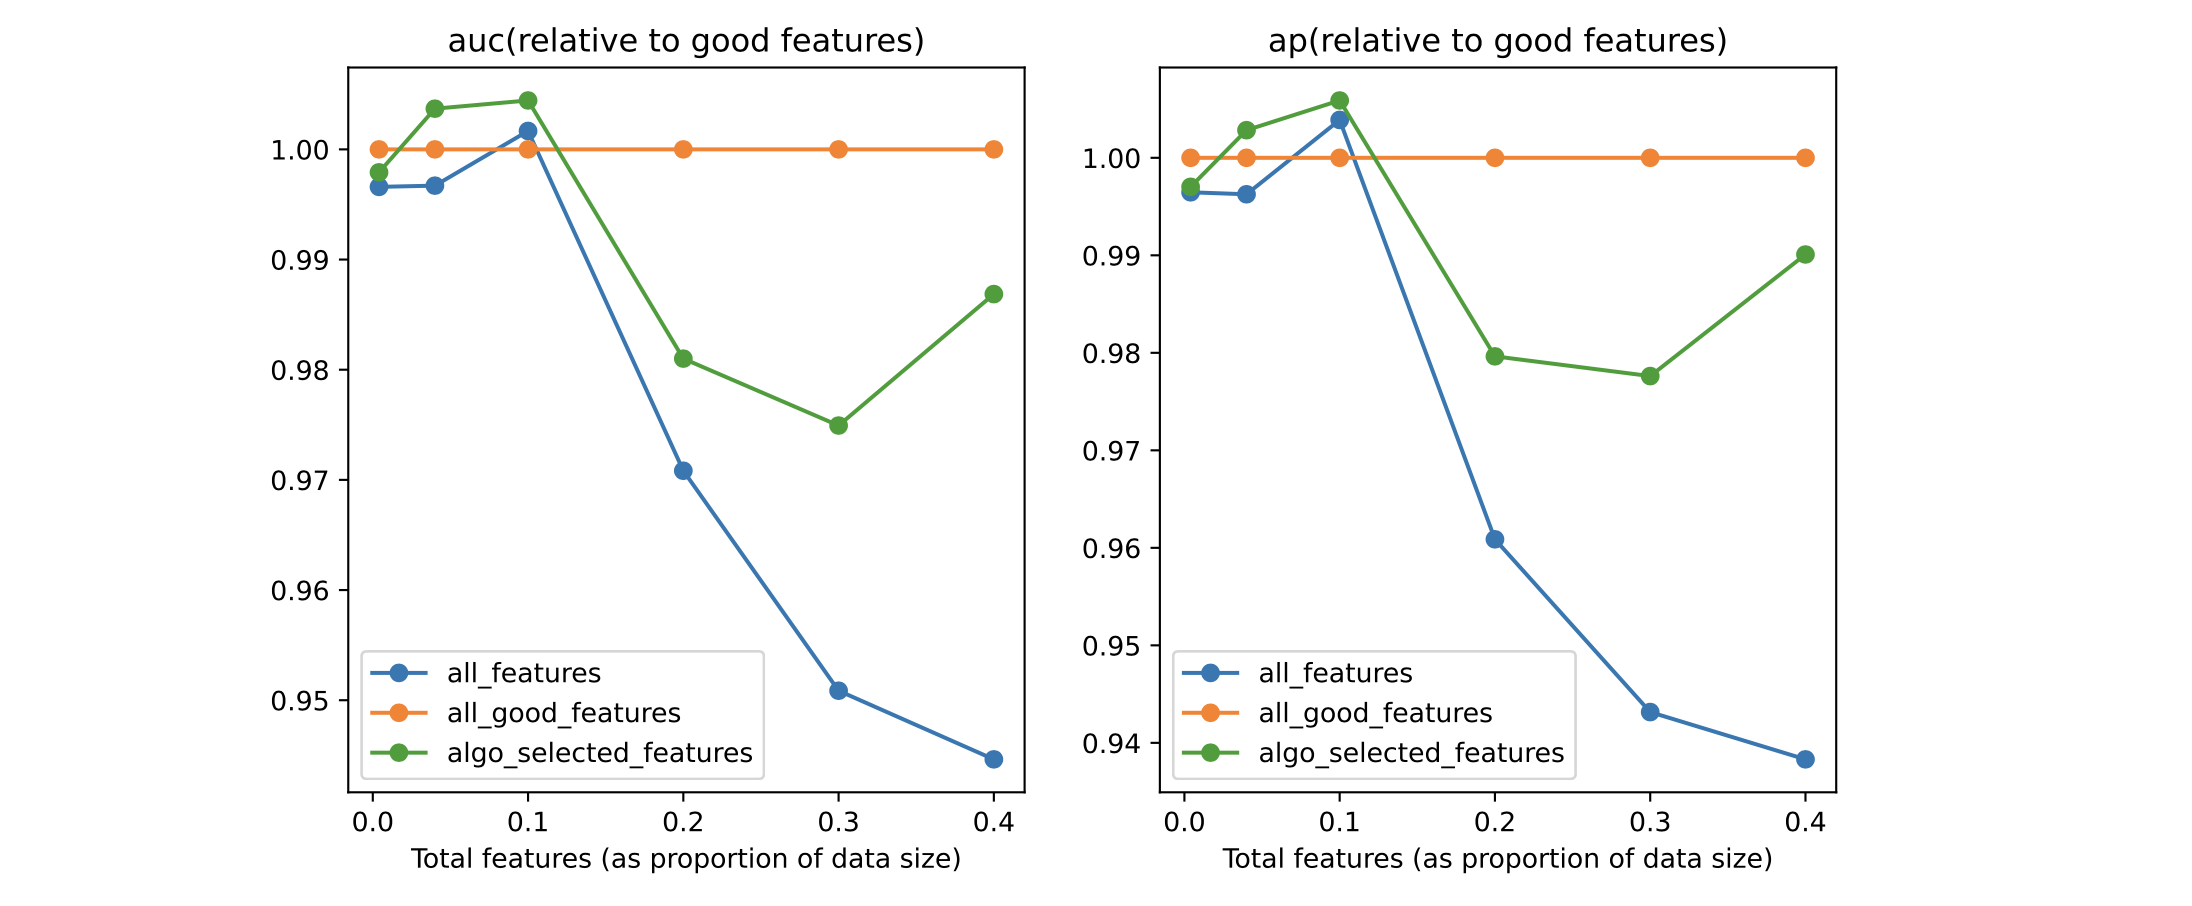

We see that, regardless of the total amount of features, the **model trained with the Boruta-selected features outperforms the one trained on all variables**. This is promising: in real life, we have no oracle, and can only hope that our feature selection algorithm chooses features in such a way as to beat the model trained on all features.

> There is a slight overfit (where the green line goes higher than the orange one) for some values, but this is fine.

We can also look at how many of the "good" features were captured by Boruta in each case:
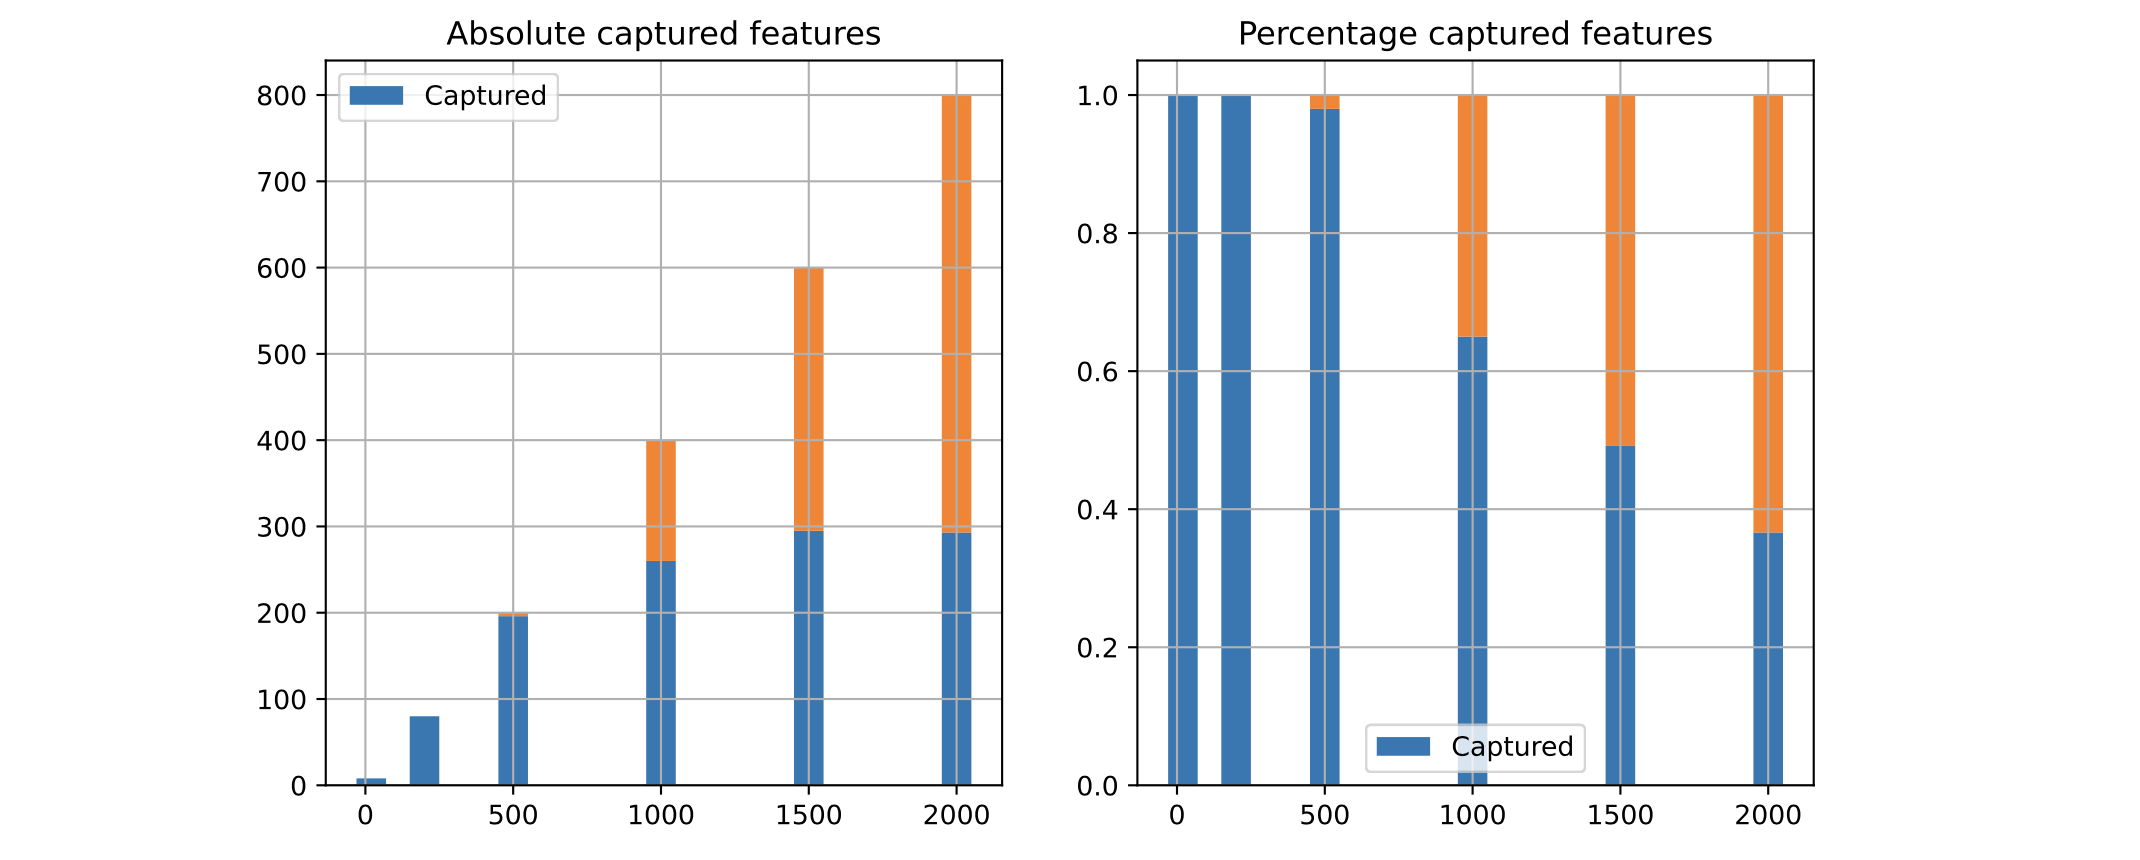

As we see, the more features in the dataset, the less Boruta is able to capture them all. With these settings, it plateaus at around 300 features. Despite that, it was able to perform better than a model which had all features available to them.

To see how important the `perc` parameter is, compare the results above with the same ones for `perc=100`:

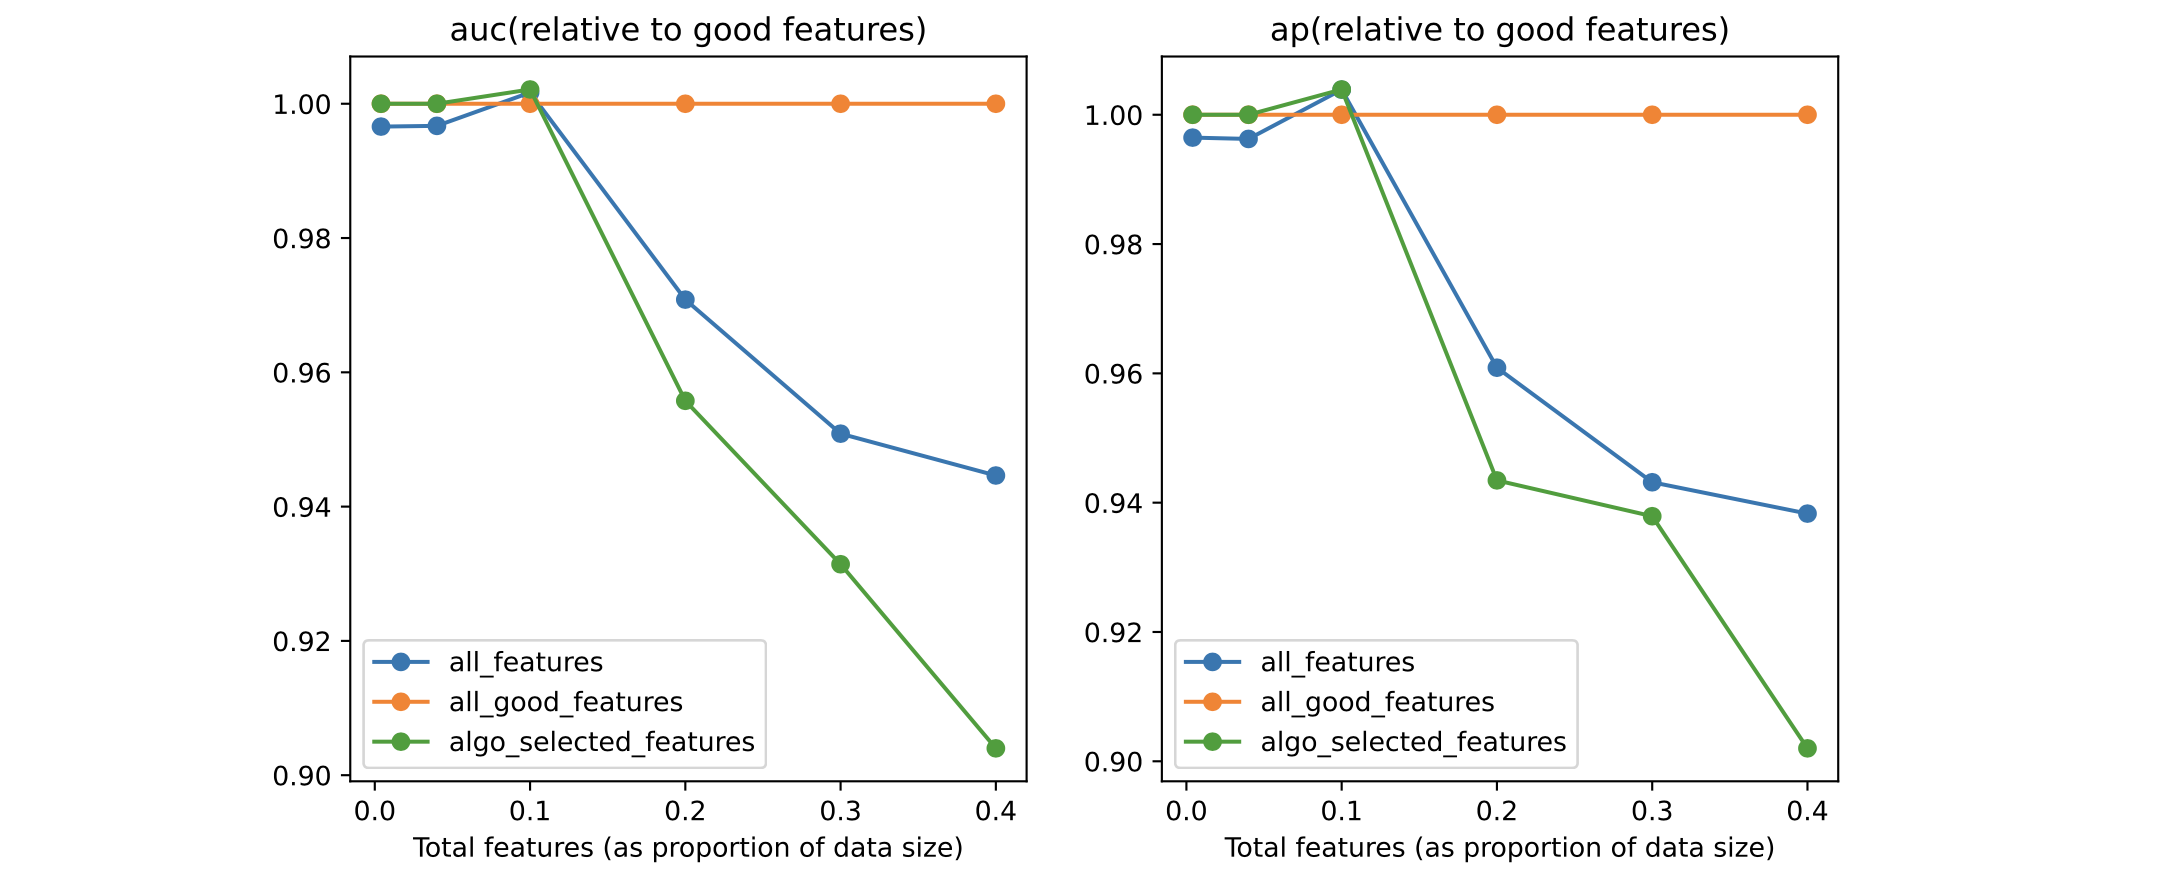

The situation is now inverted: Boruta is not able to capture enough features, and the model with selected features loses to the one using the full feature set.

Below, we show a consolidated result. In the x-axis we have `perc`; in the y-axis we have the AUC difference between a model with Boruta-selected features and one trained on the full feature set (normalized by the AUC of the model trained only with the good features). A positive value will mean that the Boruta model is better.

We do this across many feature counts. As we see, for a higher number of total features, Boruta consistently performs better than the full model if `perc` is set to values lower than 90, with the overall best between 70 and 80.

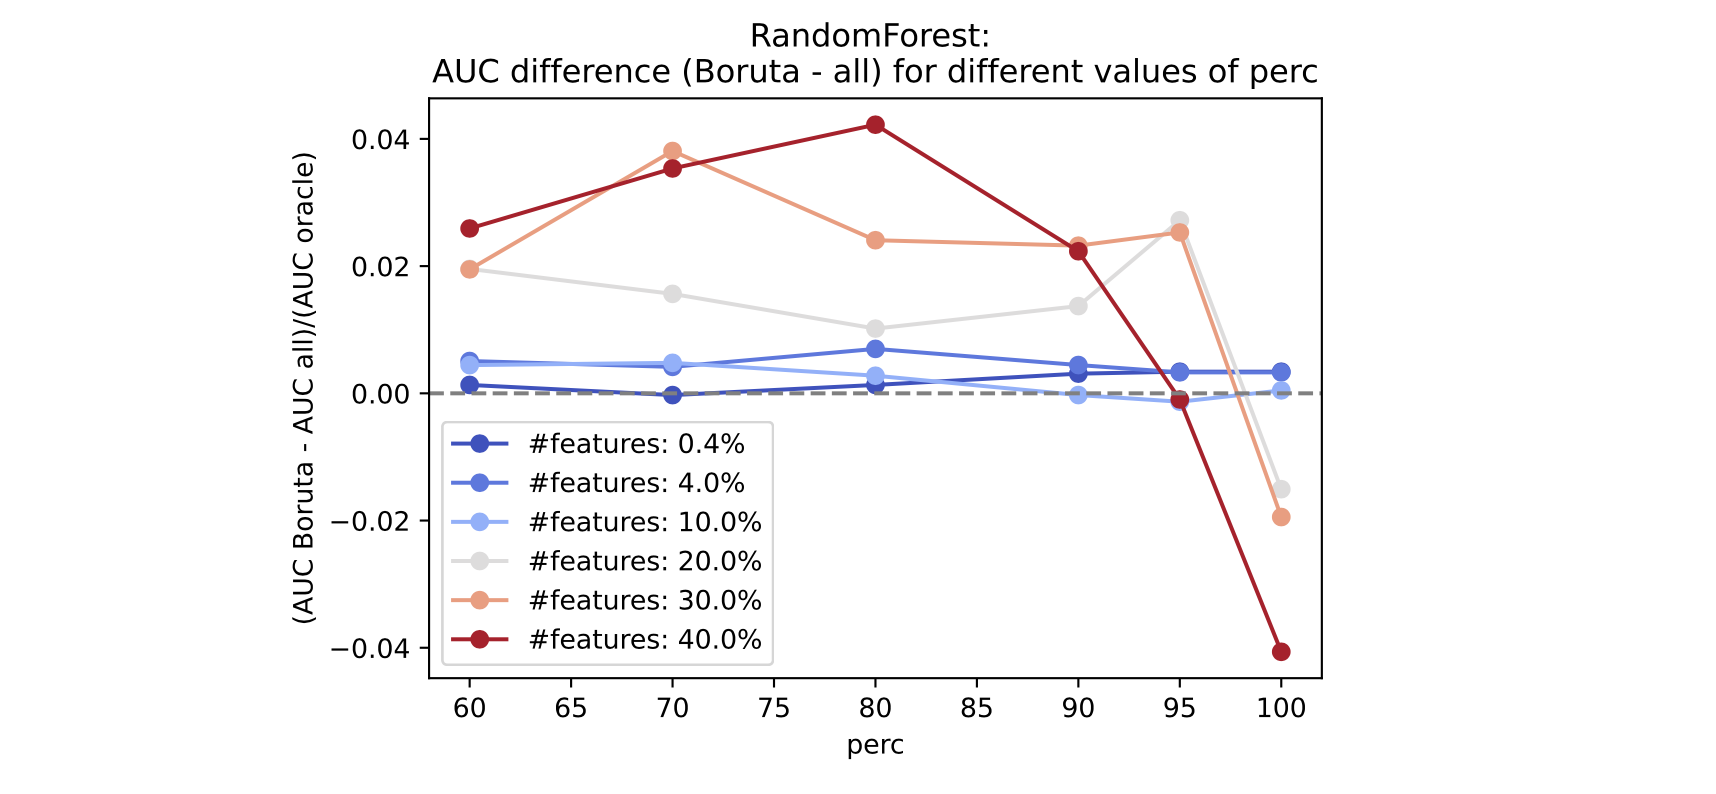

We can run a similar analysis using LightGBM as the base model:
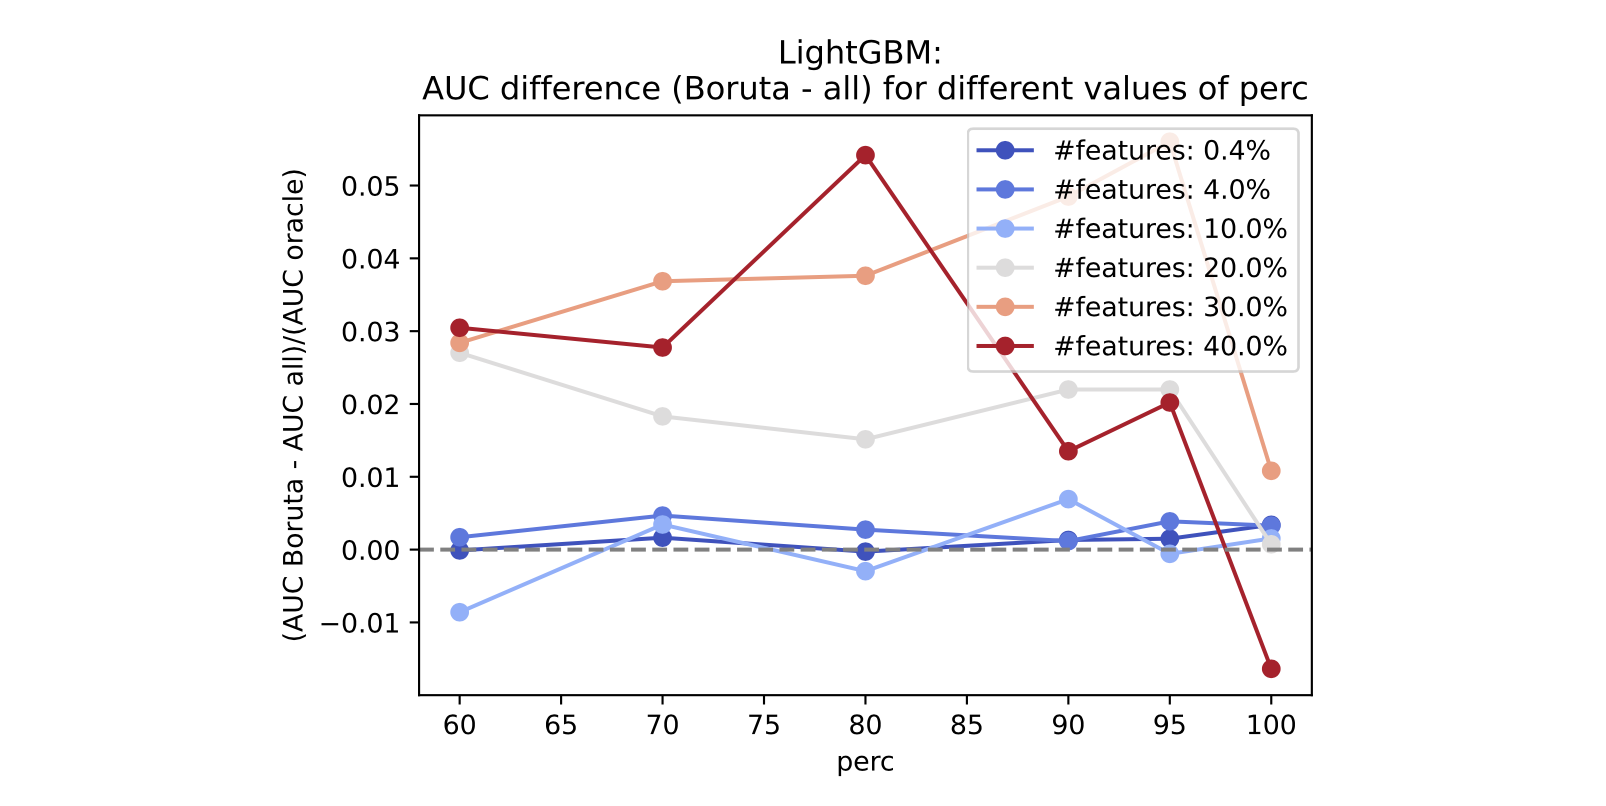

The qualitative conclusion is the same: `perc` must be set to a smaller value, and the difference between Boruta and the model trained on the full features grows as the total amount of features increases.

---

## Using Boruta on imbalanced datasets

The main question we want to answer is: is Boruta trustworthy when we are dealing with imbalanced datasets?

The approaches to this question mostly boil down to two:

1. *Undersample (1a)* or *oversample (1b)* the set we use to run the Boruta process;

2. Smartly use *weights* on the models we are using. If you have too much data on your original dataset, some undersampling, followed by using weights, also works.

Our key takeaway is translated into the following receipt:

* **Don't use Boruta in case of extreme imbalance**. Here, by extreme imbalance, we mean imbalance ratios < 1% and/or where there are less than a few hundred samples from the minority class. There are two reasons for this:
    1. As we saw in the section about feature importances & interpretability, feature importance estimations become noisy as the absolute amount of instances of the minority class becomes small. Although not necessarily always true, there is a large correlation between having extreme imbalance and simply having very few data points. Since Boruta depends on the feature importance estimates of its base learner, it will be confused by the noisy estimates and won't provide a good set of features;
    2. As the model becomes very imbalance, it also correlates with having a very large dataset. Boruta scales badly with dataset size, and using it becomes infeasible.

* If you are, however, within the parameters where using Boruta makes sense:
    1. **Use weights** via `class_weight='balanced_subsample'` in the Random Forests used as the base learner in Boruta;

    2. If you have too much data initially, adding **some undersampling first, then running item (1)**, is both more computationally efficient and effective. In the DataLab, we have verified that undersampling so that the total number of points is around **15 times the total amount of features** tends to give good results;

    3. With the selected features, train a model - here, we use  a LightGBM model with `class_weight='balanced'`.

Below, we show a few results of experiments for a dataset with imbalance ratio of 2%. We compare the undersampled, oversampled and  no-sampling, with-weights approaches.

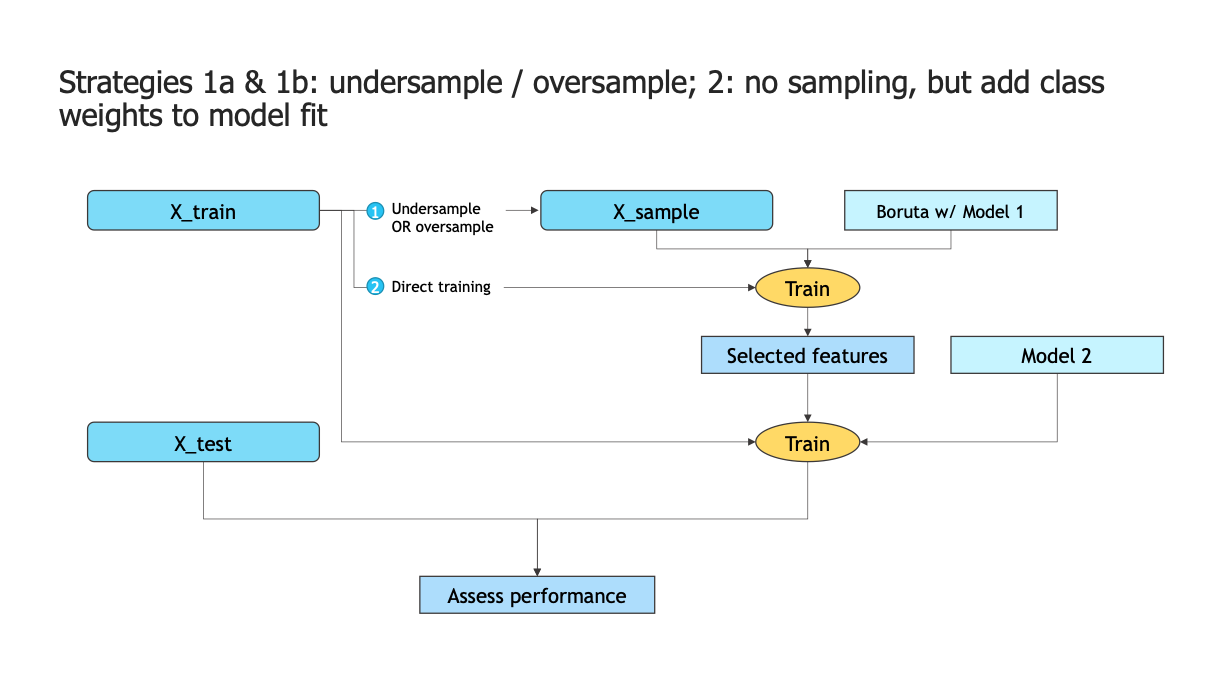

### Conclusion 1: pure undersampling is consistently worse than using weights

Dataset 1: **2% imbalance ratio**

* 4867 instances of class 0

* 133 instances of class 1 

Below, we see the results of undersampling the majority class as we increase the target balance.

* In the first plot, the Y-axis is ROC AUC. The second and third plots show, respectively, how many of the good features were captured and how many of the bad features were captured by Boruta. The orange line shows the AUC for a model containing all the good features, which we know a priori; the green line shows the performance of a model trained with all features; and the blue line shows the performance of a model trained only using the features selected via Boruta.

* Also, the dashed red line show the performance for a model trained without sampling, but simply using `class_weight='balanced_subsample'` in the Boruta base learner (Random Forest) and then `class_weight='balanced'` in the final LightGBM model. Just as before, notice there is a slight fitting to noise (surpassing the orange model, with all good features).

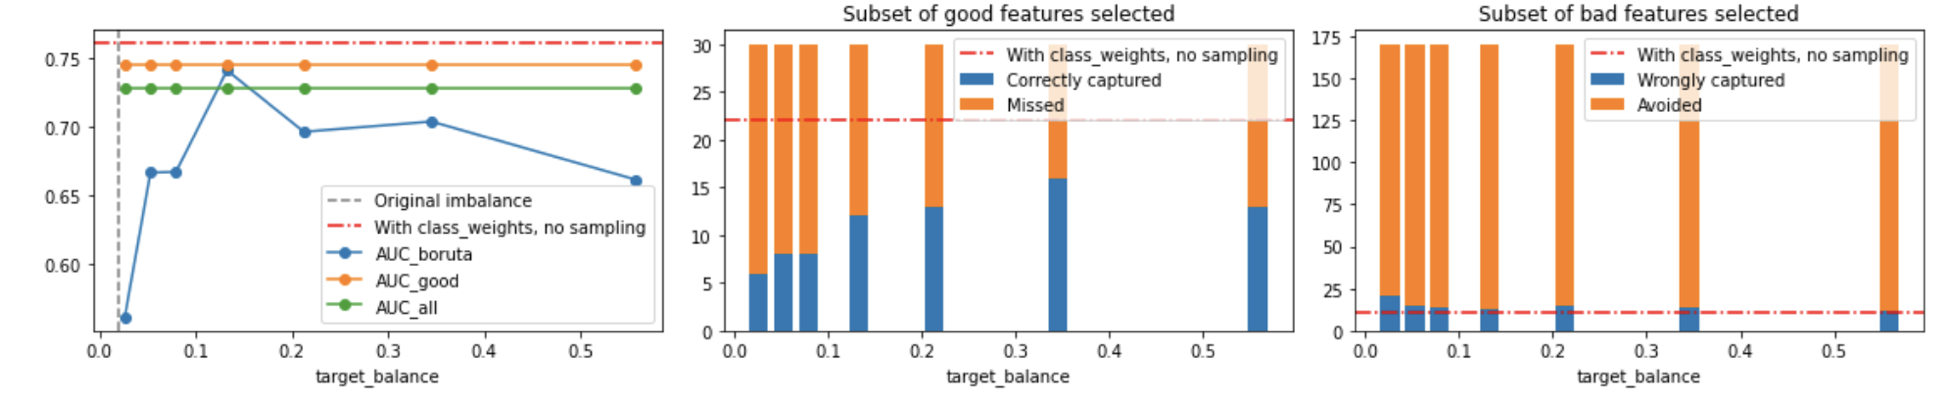

Notice how we capture more of the good features  with a model with `class_weight` than with an undersampled one; similarly, we avoid more features with it.

### Conclusion 2: oversampling is too loose (and slow)

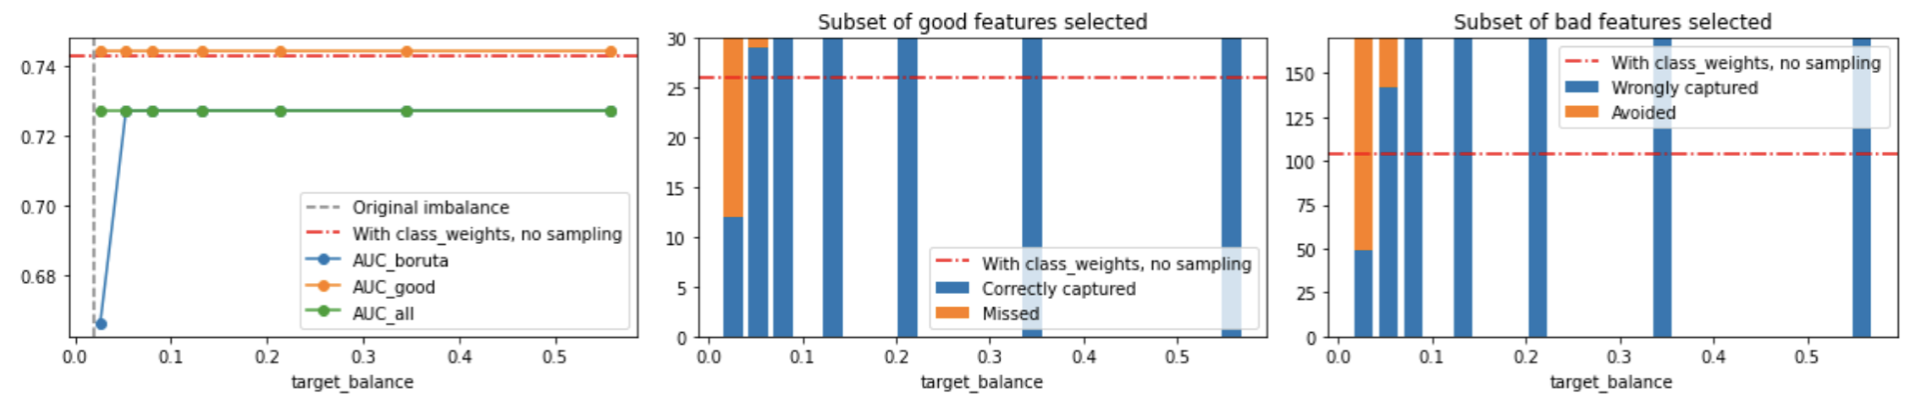

We can see that, as we increase the target balance, oversampling quickly becomes too loose and lets all features in, hence making models which are equivalent with just training with all features (also, since it increases the total amount of points, it makes Boruta slower).

### What about extreme imbalance?

To be fair, we still don't know. We have run several experiments here, but not conclusive. We are open to feedbacks here!

---

## Another approach: using SHAP values

A common approach is to calculate SHAP values and then remove the features with total contribution less than a certain threshold. This has some ambiguity on the threshold definition, and also needs to be done iteratively - after removing features, one must retrain and see the new SHAP values.

In [165]:
import shap
from sklearn.ensemble import HistGradientBoostingClassifier

In [166]:
model = HistGradientBoostingClassifier(random_state=2, max_depth=5)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=5, random_state=2)

In [167]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

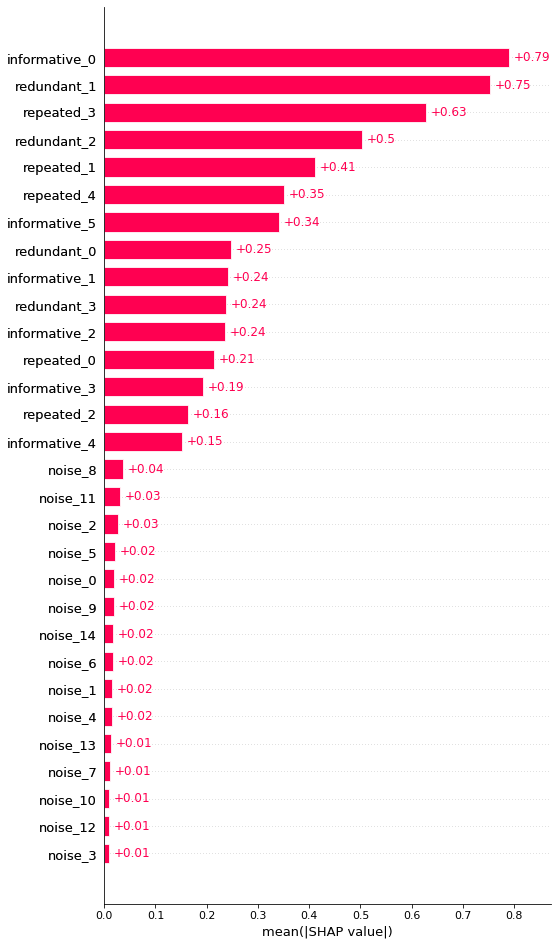

In [168]:
shap.plots.bar(shap_values, max_display=None, show=False)

We see that SHAP does a good job of finding that the noise features don't add value. Here, clearly a threshold of `mean(|SHAP|) > 0.05` seems to be a good feature selector, but this is something we have to identify visually. 

We can make this process into a function:
    

In [169]:
def shap_importances(columns, shap_values):
    importances = np.abs(shap_values.values).mean(axis=0)  # same calculation as the bar plot 
    feats_imps = pd.DataFrame({'feature': columns, 
                               'shap': importances})
    
    return feats_imps.sort_values('shap', ascending=False)

def get_important_features_from_shap(importances, threshold=0.04):
    imps = importances[importances['shap'] > threshold]
    return sorted(imps['feature'].tolist())

In [170]:
importances = shap_importances(X.columns, shap_values)
importances.head()

,feature,shap
0,informative_0,0.790061
7,redundant_1,0.751999
13,repeated_3,0.627386
8,redundant_2,0.503884
11,repeated_1,0.411533


In [171]:
features_selected_shap = get_important_features_from_shap(importances, threshold=0.05)

Rinse and repeat:

In [172]:
model = HistGradientBoostingClassifier(random_state=2, max_depth=5)
model.fit(X_train[features_selected_shap], y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train[features_selected_shap])

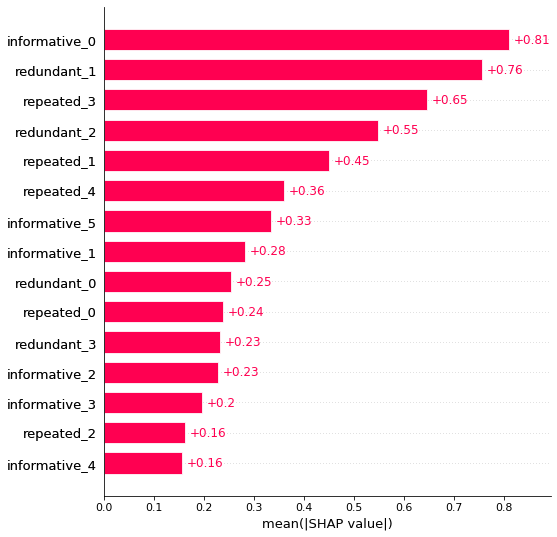

In [173]:
shap.plots.bar(shap_values, max_display=None, show=False)

There has been some rearrangement, but overall this process works. No noise features are present, but the repeated / redundant features have remained.

## Some acknowledgements

One interesting approach is to use a mix of Boruta and SHAP values: instead of using the feature importances calculated during the model training, we would instead use SHAP values.

> In tree-based classification models, splits are calculated based on Gini impurity or infomation gain. A split into new branches happens when a feature is found to decrease the total impurity. Feature importance for a given feature in a decision tree is then how much that feature contributed to the total impurity reduction. For a random forest, the feature importance attribute is the average over all trees in the forest. More details on [the scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

The [Boruta-SHAP library](https://github.com/Ekeany/Boruta-Shap) [2] does exactly that. Below, we see how to use it.
> Because SHAP value calculation is an expensive operation, this process might take much longer than the equivalent with standard feature importances.

In [177]:
from BorutaShap import BorutaShap

In [180]:
%%time
# important to pass the specific model to use; otherwise it can take a long time
selector = BorutaShap(model=RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=10),
                      percentile=100,
                      pvalue=0.05,
                      importance_measure='shap',
                      classification=True)

selector.fit(X_train, y_train,
             n_trials=100, sample=False,
             train_or_test='test', normalize=True,
             verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

15 attributes confirmed important: ['informative_3', 'repeated_1', 'repeated_3', 'informative_1', 'informative_5', 'repeated_2', 'informative_4', 'informative_0', 'redundant_3', 'redundant_0', 'redundant_1', 'redundant_2', 'repeated_4', 'repeated_0', 'informative_2']
15 attributes confirmed unimportant: ['noise_0', 'noise_12', 'noise_8', 'noise_9', 'noise_2', 'noise_7', 'noise_3', 'noise_6', 'noise_13', 'noise_4', 'noise_1', 'noise_11', 'noise_14', 'noise_10', 'noise_5']
0 tentative attributes remains: []


In [182]:
selected_columns = sorted(list(selector.Subset().columns))

In [183]:
selected_columns

['informative_0',
 'informative_1',
 'informative_2',
 'informative_3',
 'informative_4',
 'informative_5',
 'redundant_0',
 'redundant_1',
 'redundant_2',
 'redundant_3',
 'repeated_0',
 'repeated_1',
 'repeated_2',
 'repeated_3',
 'repeated_4']

It gets the right columns, but this is an extremely time-consuming algorithm. Hopefully it can be accelerated in the near future.

## Conclusions

We have presented one of our favorite feature selection methods, Boruta, as well as its limitations:

* It works well for balanced and imbalanced problems, but not for extreme imbalance (0.1% or under)

* The `perc` parameter is key: setting it to around 80 leads to better results

* We use baseline Random Forest models with fixed depth and `class_weight='balanced_subsample'`.

## References

Virus infection dataset NCBI GSE73072
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE73072

[1] Kursa, M. B., & Rudnicki, W. R. (2010). Feature Selection with the Boruta Package. Journal of Statistical Software, 36(11), 1–13. https://doi.org/10.18637/jss.v036.i11

[2] https://github.com/Ekeany/Boruta-Shap